In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,RepeatedKFold
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt # Visualizing the Satendar Customer Transactions Data
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## import data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()
features=[c for c in train.columns if c not in['ID_code','target']]


## data exploration

In [3]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [16]:
train.shape

(200000, 202)

In [17]:
train.head(20)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


## Check for the Missing Values.

In [18]:
obs=train.isnull().sum().sort_values(ascending = False)
percent=round(train.isnull().sum().sort_values(ascending=False)/len(train)*100,2)
obss=pd.concat([obs,percent],axis=1,keys= ['Number of Observations', 'Percent'])
obss.isnull().sum()
#There are no missing values in the dataset

Number of Observations    0
Percent                   0
dtype: int64

## Visualizing the Satendar Customer Transactions Data

In [19]:
##Check for Class Imbalance

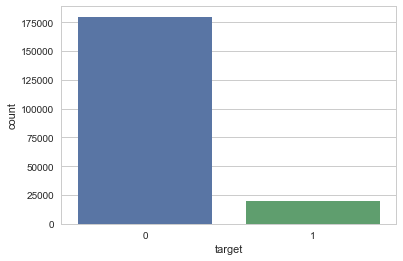

In [20]:
target=train['target']
train=train.drop(["ID_code","target"],axis=1)
sns.set_style('whitegrid')
sns.countplot(target)


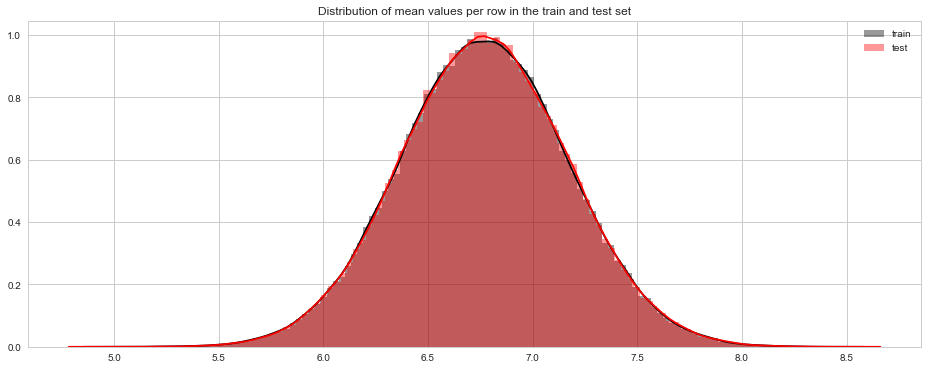

In [21]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="black",kde=True, bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="red", kde=True, bins=120, label='test')
plt.legend()##显示图例
plt.show()


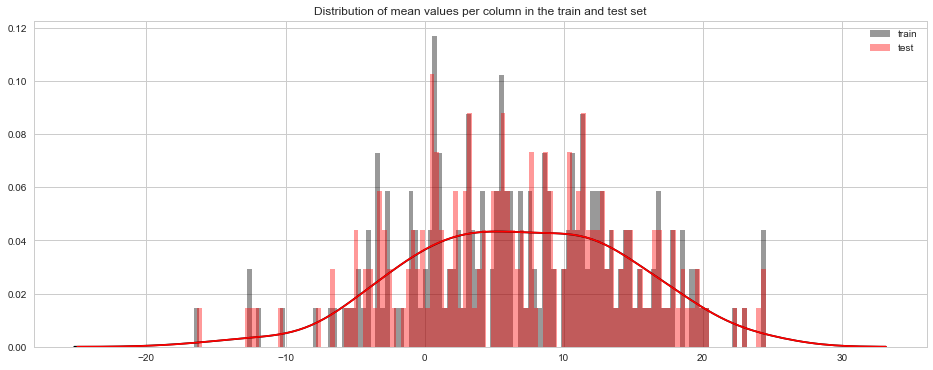

In [22]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

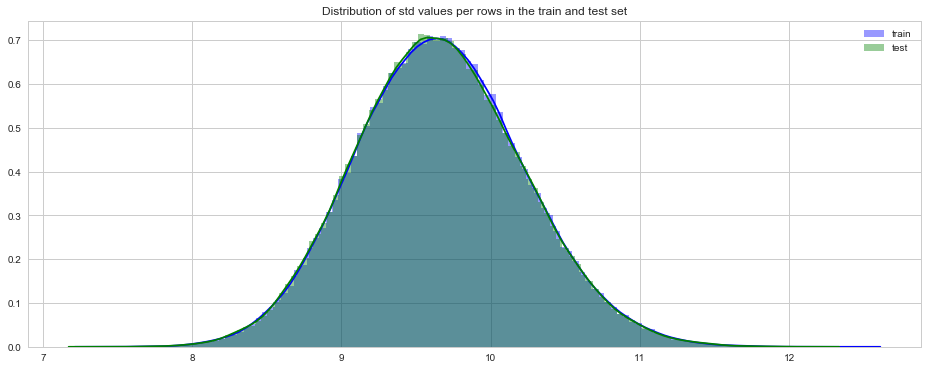

In [23]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per rows in the train and test set")
sns.distplot(train[features].std(axis=1),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="green", kde=True, bins=120, label='test')
plt.legend(); plt.show()


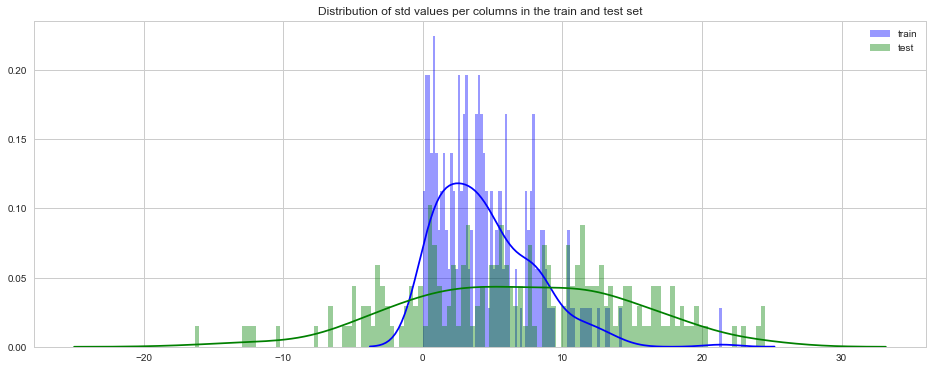

In [24]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per columns in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120,label="train")
sns.distplot(test[features].mean(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

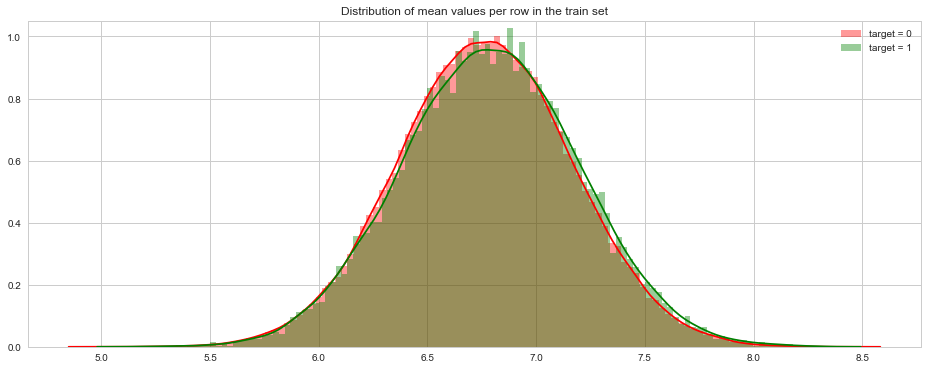

In [25]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

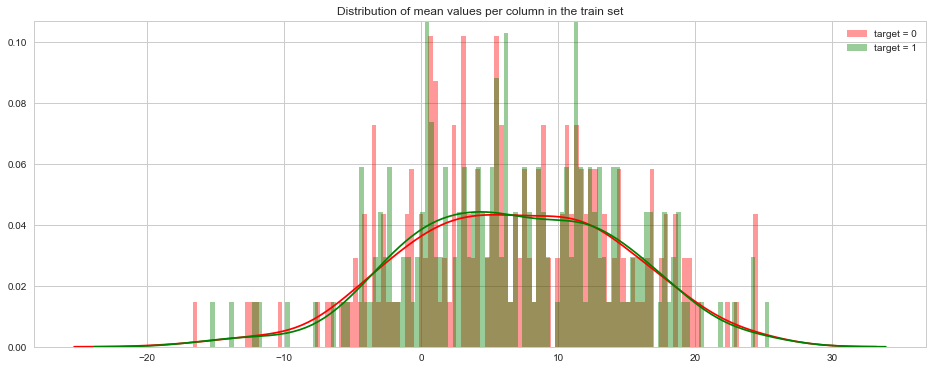

In [26]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

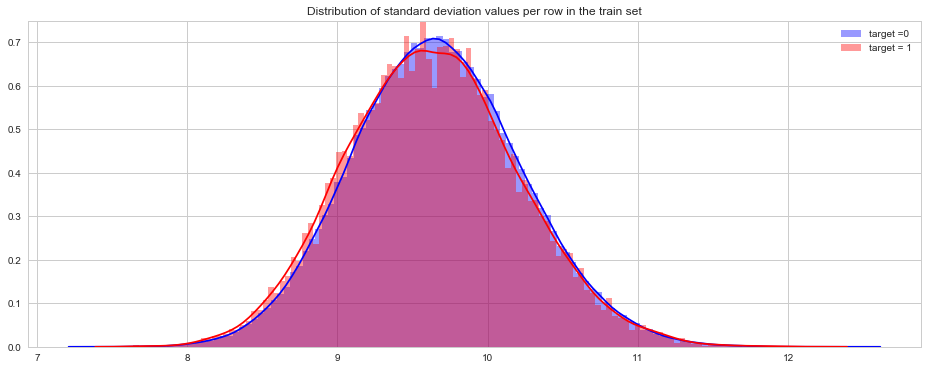

In [27]:
t0=train.loc[target==0]
t1=train.loc[target==1]
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per row in the train set")
sns.distplot(t0[features].std(axis=1),color="blue",kde=True,bins=120,label='target =0 ')
sns.distplot(t1[features].std(axis=1),color="red", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

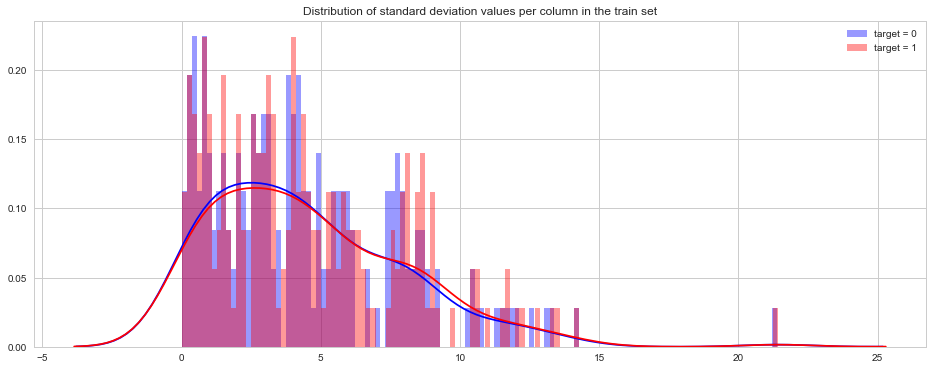

In [28]:
t0 = train.loc[target  == 0]
t1 = train.loc[target  == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per column in the train set")
sns.distplot(t0[features].std(axis=0),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=0),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## Distribution of Skewness

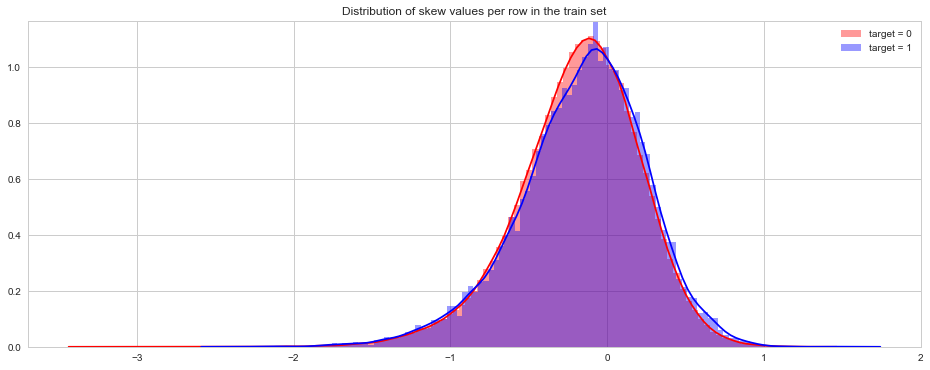

In [29]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()
#Let's see now the distribution of skewness on rows in train separated for values of target 0 and 1. We found the distribution is left skewed

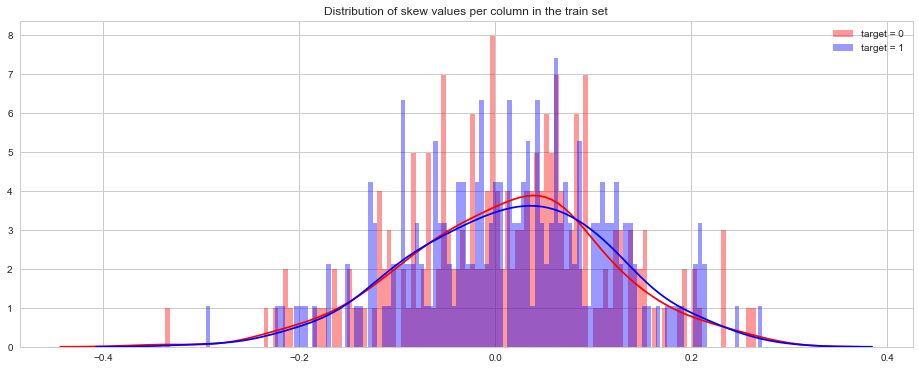

In [30]:
#Let's see now the distribution of skewness on columns in train separated for values of target 0 and 1.
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

In [31]:
#Let's see now the distribution of kurtosis on rows in train separated for values of target 0 and 1. We found the distribution to be Leptokurtic

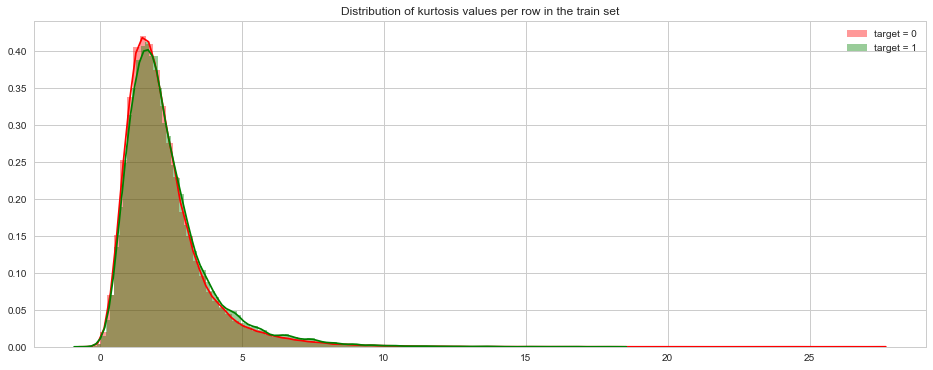

In [32]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

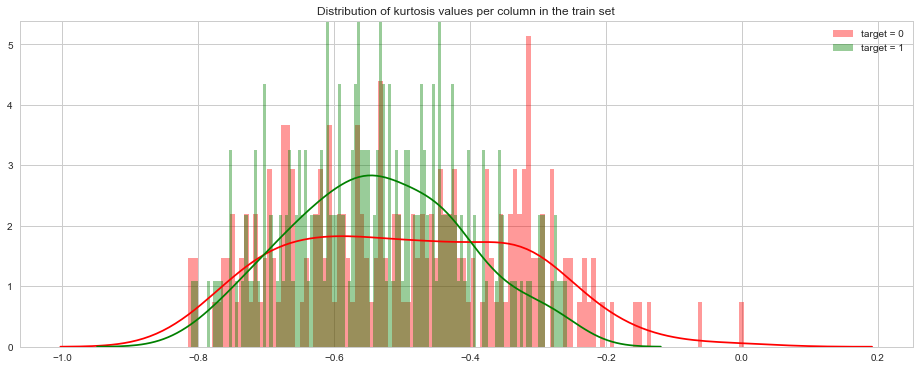

In [33]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()


In [34]:
##Principal Component Analysis to check Dimentionality Reduction

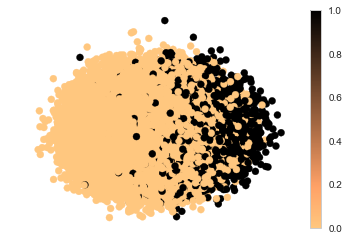

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_scaled=scaler.fit_transform(train)
PCA_train_x=PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:,0],PCA_train_x[:,1],c=target,cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()
# scaler = StandardScaler()
# train_scaled = scaler.fit_transform(train)         
# PCA_train_x = PCA(2).fit_transform(train_scaled)
# plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="copper_r")
# plt.axis('off')
# plt.colorbar()
# plt.show()

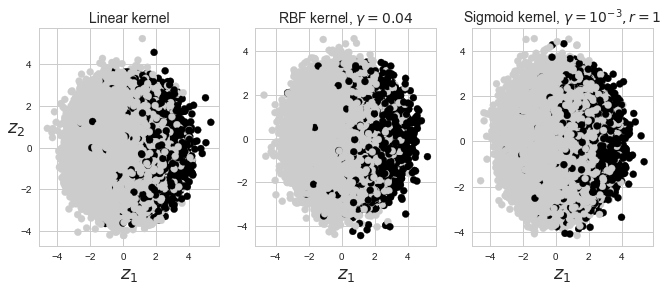

In [36]:
##Kernel PCA (Since the Graph above doesn't represent meaningful analysis)

from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

#Since PCA hasn't been useful, I decided to proceed with the existing dataset
## Data Augmentation

In [37]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

## Build the Light GBM Model

## lightgbm model

In [38]:
param = {
    'bagging_freq': 5, #k 意味着每 k 次迭代执行bagging
    'bagging_fraction': 0.335,#建树的样本采样比例
    'boost_from_average':'false',#
    'boost': 'gbdt',
    'feature_fraction': 0.041,# 建树的特征选择比例，比如为0.8时，意味着在每次迭代中随机选择80％的参数来建树
    'learning_rate': 0.0083,# 学习速率
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,#一个叶子上数据的最小数量
    'min_sum_hessian_in_leaf': 10.0, #一个叶子上的最小 hessian 和. 类似于 min_data_in_leaf, 可以用来处理过拟合
    'num_leaves': 13,# 叶子节点数
    'num_threads': 8,#指定线程的个数
    'tree_learner': 'serial',
    'objective': 'binary', #application：默认为regression。，也称objective， app这里指的是任务目标
    'verbosity': -1
}

In [39]:
train.shape

(200000, 200)

In [40]:
num_folds = 5
features = [c for c in train.columns if c not in ['ID_code', 'target']]

folds = StratifiedKFold(n_splits=num_folds, shuffle=False, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    # fold_importance_df 保存了所有特征的在每个folder的importance，用于后面的画图。
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.893779	valid_1's auc: 0.882072
[2000]	training's auc: 0.901676	valid_1's auc: 0.888562
[3000]	training's auc: 0.906684	valid_1's auc: 0.892281
[4000]	training's auc: 0.910561	valid_1's auc: 0.89499
[5000]	training's auc: 0.913549	valid_1's auc: 0.89653
[6000]	training's auc: 0.916076	valid_1's auc: 0.897764
[7000]	training's auc: 0.918419	valid_1's auc: 0.898663
[8000]	training's auc: 0.920554	valid_1's auc: 0.899313
[9000]	training's auc: 0.922487	valid_1's auc: 0.899787
[10000]	training's auc: 0.924341	valid_1's auc: 0.900063
[11000]	training's auc: 0.926092	valid_1's auc: 0.900297
[12000]	training's auc: 0.927796	valid_1's auc: 0.900423
[13000]	training's auc: 0.929485	valid_1's auc: 0.900445
[14000]	training's auc: 0.931114	valid_1's auc: 0.900458
[15000]	training's auc: 0.932721	valid_1's auc: 0.900512
[16000]	training's auc: 0.934277	valid_1's auc: 0.90047
[17000]	t

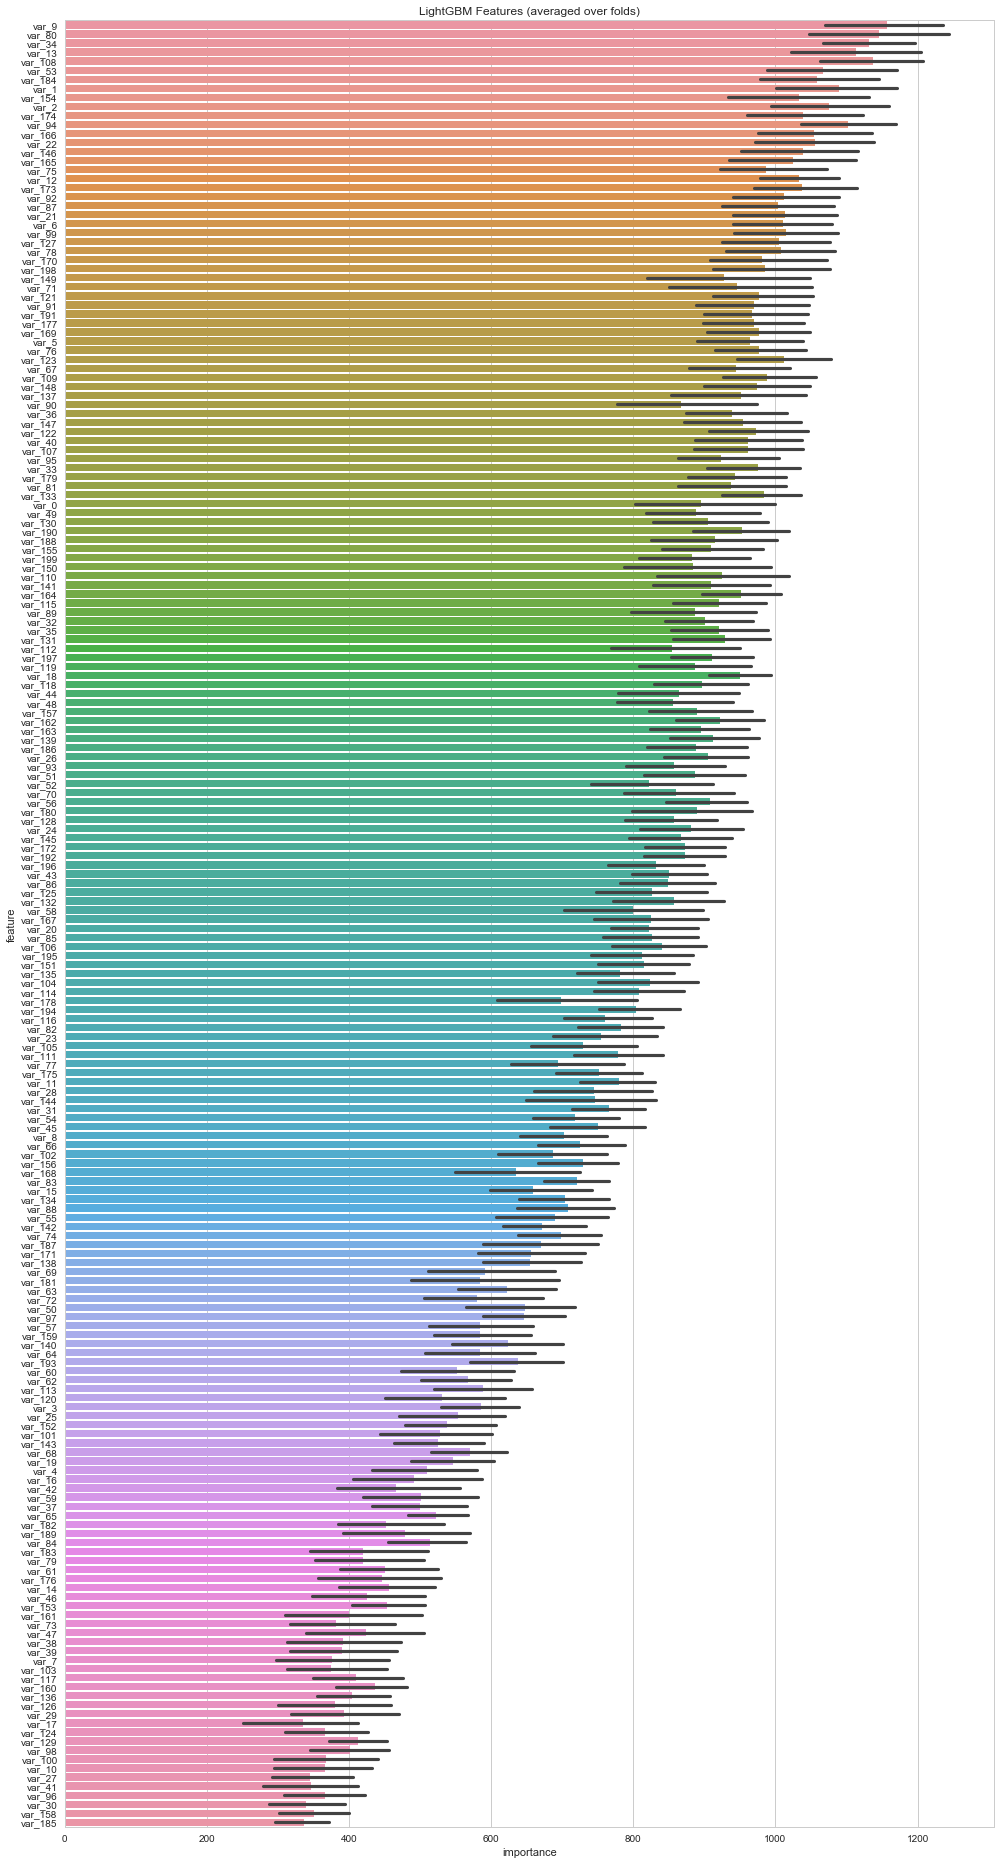

In [41]:
# 根据feature进行分组，然后取平均算出每个feature的importance的平均值。之后画图。
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [42]:
num_sub = 1
print('Saving the Submission File')
sub = pd.DataFrame({"ID_code": test.ID_code.values})
sub["target"] = predictions
sub.to_csv('submission{}.csv'.format(num_sub), index=False)
getValue = pd.DataFrame(getVal)
getValue.to_csv("Validation.csv")

Saving the Submission File
